In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse

In [3]:
archs = np.array([[-1,-1],
                  [2,-2],
                  [-2,2]])

In [4]:
X,Y = archs.T

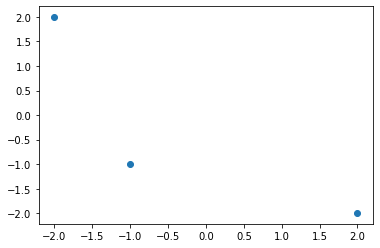

In [5]:
plt.scatter(X,Y)

In [6]:
def generate_data (archs, n_points, noise=0.1):
    k = len(archs)
    X,Y = archs.T 
    rand = np.random.uniform (0,1,[k,n_points])
    rand = (rand/np.sum(rand,axis=0)).T
    data = np.matmul(rand,archs)
    data = data + np.random.normal(0,noise,size=data.shape)
    return data

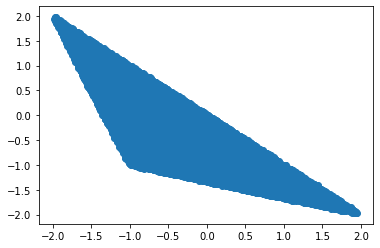

In [7]:
x_train = generate_data (archs,100000,noise=0.01)
x_test = generate_data (archs,10000,noise=0.01)

dataX,dataY = x_train.T
plt.scatter(dataX,dataY)

In [48]:
def get_zfixed ( dim_latent_space ):
    
    z_fixed_t = np.zeros([dim_latent_space, dim_latent_space + 1])

    for k in range(0, dim_latent_space):
        s = 0.0
        for i in range(0, k):
            s = s + z_fixed_t[i, k] ** 2
  
        z_fixed_t[k, k] = np.sqrt(1.0 - s)

        for j in range(k + 1, dim_latent_space + 1):
            s = 0.0
            for i in range(0, k):
                s = s + z_fixed_t[i, k] * z_fixed_t[i, j]

            z_fixed_t[k, j] = (-1.0 / float(dim_latent_space) - s) / z_fixed_t[k, k]
            z_fixed = np.transpose(z_fixed_t)
                    
    return z_fixed


In [52]:
def sampling(args):
    
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim),stddev=0.01)

    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
original_dim = x_train.shape[1]
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])

# network parameters
input_shape = (original_dim, )
intermediate_dim = 16
batch_size = 256
latent_dim = 2
simplex_vrtxs = latent_dim + 1
epochs = 20


# encoder
inputs = Input(shape=input_shape, name='encoder_input')
x_enc = Dense(intermediate_dim, activation='relu')(inputs)
A = Dense (simplex_vrtxs, activation=tf.nn.softmax)(x_enc)
B_t = Dense (simplex_vrtxs)(x_enc)
B = tf.nn.softmax(tf.transpose(B_t), axis=1)

z_fixed = get_zfixed (latent_dim)
z_fixed = tf.constant (z_fixed, dtype='float32')
mu = tf.matmul(A, z_fixed)
z_pred = tf.matmul(B,mu)
sigma = Dense(latent_dim)(x_enc)
t = Lambda(sampling, name='t')([mu, sigma])
encoder = Model(inputs, [t,mu,sigma], name='encoder')
encoder.summary()

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x_dec = Dense(intermediate_dim, activation='relu')(latent_inputs)

outputs = Dense(original_dim, activation='linear')(x_dec)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# VAE
outputs = decoder(encoder(inputs)[0])
vae = Model(inputs, outputs, name='vae')


reconstruction_loss = mse(inputs, outputs)
archetype_loss = tf.reduce_sum(mse(z_fixed, z_pred))

kl_loss = 1 + sigma - tf.square(mu) - tf.exp(sigma)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
beta = 1


vae_loss = tf.reduce_mean(reconstruction_loss + beta*kl_loss) # + archetype_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()


vae.fit(x_train, y=None,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_121 (Dense)               (None, 16)           48          encoder_input[0][0]              
__________________________________________________________________________________________________
dense_122 (Dense)               (None, 3)            51          dense_121[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_MatMul_35 (TensorFl [(None, 2)]          0           dense_122[0][0]                  
____________________________________________________________________________________________

Epoch 7/20
100000/100000 [==============================] - 2s 19us/sample - loss: 0.0115 - val_loss: 0.0115
Epoch 8/20
100000/100000 [==============================] - 3s 26us/sample - loss: 0.0114 - val_loss: 0.0115
Epoch 9/20
100000/100000 [==============================] - 2s 22us/sample - loss: 0.0114 - val_loss: 0.0115
Epoch 10/20
100000/100000 [==============================] - 2s 20us/sample - loss: 0.0114 - val_loss: 0.0114
Epoch 11/20
100000/100000 [==============================] - 2s 17us/sample - loss: 0.0114 - val_loss: 0.0115
Epoch 12/20
100000/100000 [==============================] - 2s 17us/sample - loss: 0.0114 - val_loss: 0.0114
Epoch 13/20
100000/100000 [==============================] - 2s 23us/sample - loss: 0.0114 - val_loss: 0.0114
Epoch 14/20
100000/100000 [==============================] - 2s 18us/sample - loss: 0.0114 - val_loss: 0.0114
Epoch 15/20
100000/100000 [==============================] - 2s 16us/sample - loss: 0.0113 - val_loss: 0.0114
Epoch 16/20
1

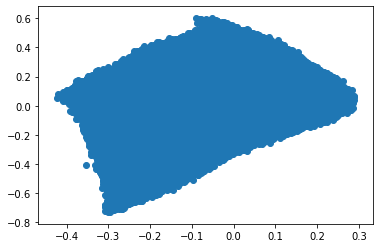

In [66]:
x_pred = encoder.predict(x_train)
dataX,dataY = x_pred[0].T
plt.scatter(dataX,dataY)


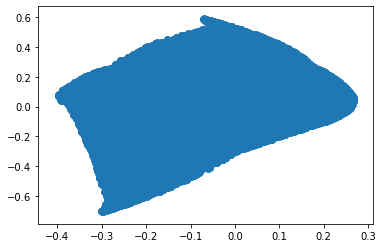

In [67]:
x_pred = encoder.predict(x_train)
dataX,dataY = x_pred[1].T
plt.scatter(dataX,dataY)


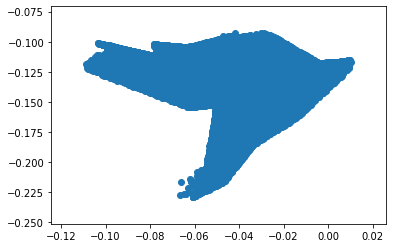

In [68]:
x_pred = encoder.predict(x_train)
dataX,dataY = x_pred[2].T
plt.scatter(dataX,dataY)


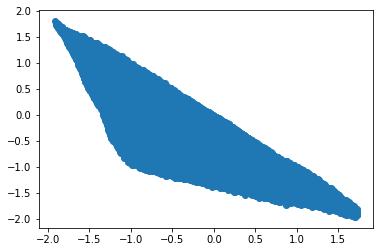

In [69]:
x_pred = vae.predict(x_train)
dataX,dataY = x_pred.T
plt.scatter(dataX,dataY)


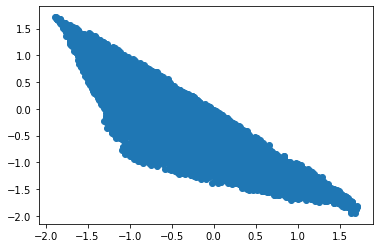

In [70]:
x_pred = vae.predict(x_test)
dataX,dataY = x_pred.T
plt.scatter(dataX,dataY)
